In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
np.random.seed(7)

In [4]:
data_path = "/content/gdrive/My Drive/Project/Stocks/"

In [5]:
def get_all_files(data_path=data_path):
    all_files = []

    for file in os.listdir(data_path)[:100]:
        f = open(data_path+file)
        if len(f.readlines()) > 100: 
            all_files.append(data_path+file)
        f.close()
    
    return all_files

all_files = get_all_files()

In [6]:
n = len(all_files)

all_files = np.array(all_files, dtype=str)
np.random.shuffle(all_files)

training_files = all_files[:int(n*0.6)] 
validation_files = all_files[int(n*0.6):int(n*0.8)]
test_files = all_files[int(n*0.8):]

In [7]:
def transform_data(file, K):
    X, T = [], []

    f = open(file, "r")

    data = []
    for line in f.readlines()[-100:]:
        line = line.split(",")[1:-2]

        data.append(line)
        if len(data) == K+1:
            x = np.array(data[:-1], dtype=float)
            X.append(x)
            T.append(float(data[-1][-1]))

            data = data[1:]

    f.close()
    
    return torch.tensor(X, dtype=torch.float), torch.tensor(T, dtype=torch.float)

In [8]:
class StocksRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(StocksRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # out, _ = self.rnn(x)
        # out = self.fc(out[:, -1, :])
        # return out
        s1, s2, s3 = x.shape
        x = x.reshape(s1, s2*s3)
        min, max = torch.amin(x, axis=1), torch.amax(x, axis=1)
        x = (x-min[:, np.newaxis]) / (max[:, np.newaxis] - min[:, np.newaxis])
        x = x.reshape(s1, s2, s3)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return ((out.reshape(-1) * (max-min)) + min).reshape(-1, 1)

class StocksLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(StocksLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # out, _ = self.lstm(x)
        # out = self.fc(out[:, -1, :])
        # return out
        s1, s2, s3 = x.shape
        x = x.reshape(s1, s2*s3)
        min, max = torch.amin(x, axis=1), torch.amax(x, axis=1)
        x = (x-min[:, np.newaxis]) / (max[:, np.newaxis] - min[:, np.newaxis])
        x = x.reshape(s1, s2, s3)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return ((out.reshape(-1) * (max-min)) + min).reshape(-1, 1)


In [9]:
def get_mean_error(model, crit, files, K):
    T, Y = [], []
    for f in files:
        x, t = transform_data(f, K)
        output = model(x)
        T.append(t)
        Y.append(output)

    T = torch.concat(T, 0)
    Y = torch.concat(Y, 0)
    return crit(Y, T.reshape(-1, 1)).detach().numpy()

In [10]:
def train_rnn_network(model, train, valid, num_epochs=100, batch_size=5, learning_rate=1e-5, K=5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []

    iter_x = []
    iter_t = []
    for f in train:
        x, t = transform_data(f, K)
        iter_x.append(x)
        iter_t.append(t)

    train_data_x = torch.concat(iter_x, 0)
    train_data_t = torch.concat(iter_t, 0)
    print(train_data_x.shape)

    for epoch in range(num_epochs):

        p = np.random.permutation(train_data_t.shape[0])
        X, T = train_data_x[p], train_data_t[p]

        for i in range(0, int(T.shape[0]), batch_size):
            batch_x = X[i: (i+batch_size)]
            batch_t = T[i: (i+batch_size)]
            pred = model(batch_x)
            loss = criterion(pred, batch_t.reshape(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_mean_error(model, criterion, train, K))
        valid_acc.append(get_mean_error(model, criterion, valid, K))
        if (epoch+1) % 10 == 0:
            print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
                epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

<ipython-input-7-1a1e3b3329d3>:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(X, dtype=torch.float), torch.tensor(T, dtype=torch.float)


torch.Size([5130, 5, 4])
Epoch 10; Loss 0.572537; Train Acc 1.037852; Val Acc 1.224261
Epoch 20; Loss 0.705882; Train Acc 0.756602; Val Acc 0.934999
Epoch 30; Loss 0.983559; Train Acc 0.584463; Val Acc 0.782603
Epoch 40; Loss 0.596569; Train Acc 0.530243; Val Acc 0.751554
Epoch 50; Loss 0.644341; Train Acc 0.510768; Val Acc 0.734563
Epoch 60; Loss 0.676688; Train Acc 0.494610; Val Acc 0.711665
Epoch 70; Loss 0.403325; Train Acc 0.479310; Val Acc 0.687145
Epoch 80; Loss 0.510935; Train Acc 0.464031; Val Acc 0.663195
Epoch 90; Loss 0.535348; Train Acc 0.448588; Val Acc 0.638431
Epoch 100; Loss 1.090306; Train Acc 0.434560; Val Acc 0.615347


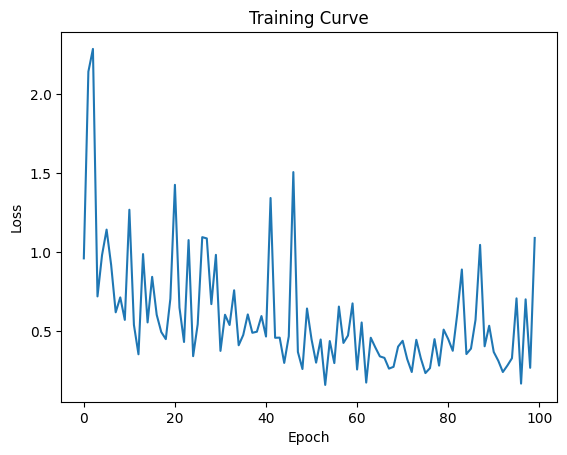

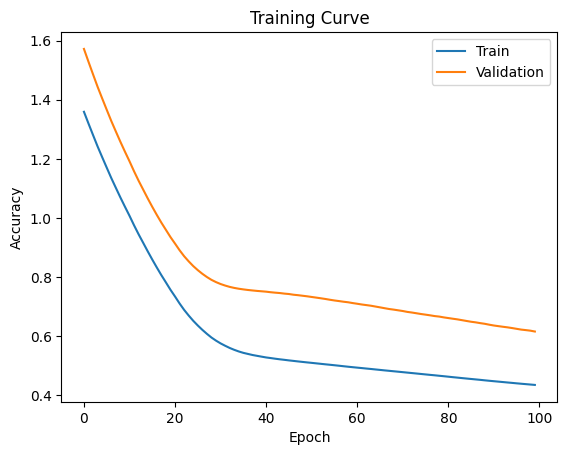

Test Data Accuracy:  0.92193013


In [11]:
modelRNN = StocksRNN(4, 150)
train_rnn_network(modelRNN, 
                  training_files, 
                  validation_files, 
                  num_epochs=100, 
                  batch_size=500, 
                  learning_rate=1e-5,
                  K=5)
print("Test Data Accuracy: ", get_mean_error(modelRNN, nn.MSELoss(), test_files, 10))

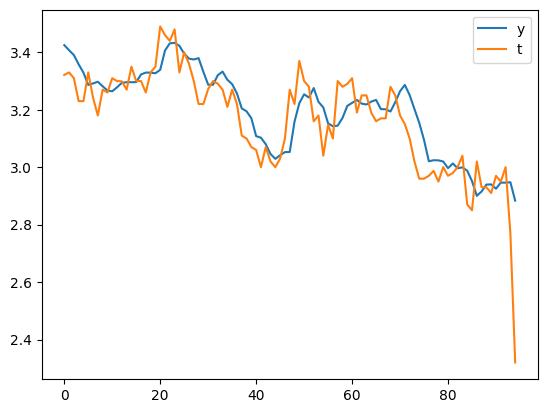

In [12]:
X, T = transform_data(test_files[0], 5)
Y = modelRNN(X)

plt.plot(np.arange(len(Y)), Y.detach().numpy(), label="y")
plt.plot(np.arange(len(T)), T, label="t")
plt.legend()
plt.show()

torch.Size([5130, 5, 4])
Epoch 10; Loss 1.506756; Train Acc 1.284846; Val Acc 1.491527
Epoch 20; Loss 0.717980; Train Acc 1.184503; Val Acc 1.382721
Epoch 30; Loss 0.921859; Train Acc 1.083742; Val Acc 1.274655
Epoch 40; Loss 0.701232; Train Acc 0.979262; Val Acc 1.164384
Epoch 50; Loss 0.556167; Train Acc 0.876383; Val Acc 1.058444
Epoch 60; Loss 0.739997; Train Acc 0.775381; Val Acc 0.958723
Epoch 70; Loss 0.343749; Train Acc 0.687870; Val Acc 0.878809
Epoch 80; Loss 0.513796; Train Acc 0.622580; Val Acc 0.828162
Epoch 90; Loss 0.247599; Train Acc 0.585967; Val Acc 0.808587
Epoch 100; Loss 1.184520; Train Acc 0.568421; Val Acc 0.804252


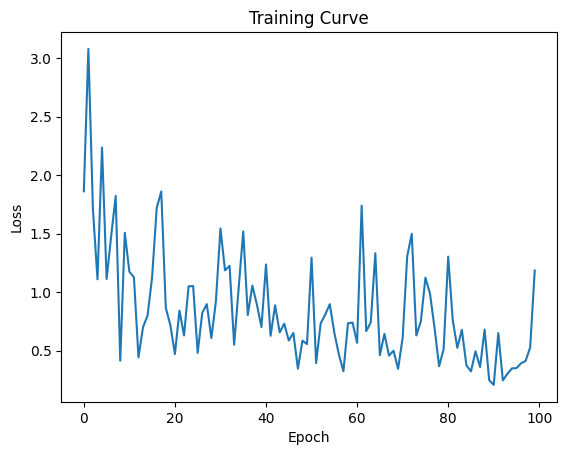

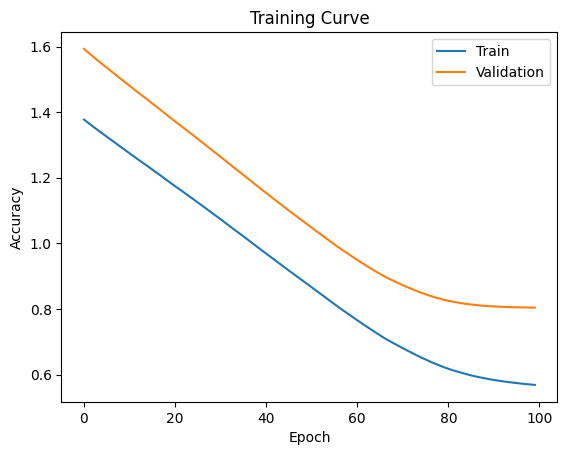

Test Data Accuracy:  0.81516415


In [13]:
modelLSTM = StocksLSTM(4, 150)
train_rnn_network(modelLSTM, 
                  training_files, 
                  validation_files, 
                  num_epochs=100, 
                  batch_size=500, 
                  learning_rate=1e-5,
                  K=5)
print("Test Data Accuracy: ", get_mean_error(modelLSTM, nn.MSELoss(), test_files, 5))

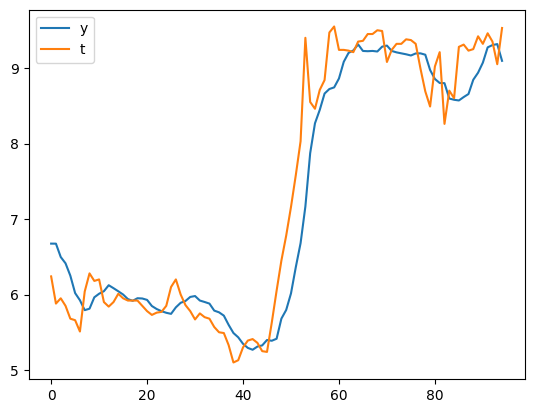

Test Data Accuracy:  0.81516415


In [14]:
X, T = transform_data(test_files[1], 5)
Y = modelLSTM(X)

plt.plot(np.arange(len(Y)), Y.detach().numpy(), label="y")
plt.plot(np.arange(len(T)), T, label="t")
plt.legend()
plt.show()

print("Test Data Accuracy: ", get_mean_error(modelLSTM, nn.MSELoss(), test_files, 5))